# pytorch手把手實作: 物件偵測模型-偵測人臉為例
<br>
<font size=4> 
    
資料集: [待上傳]() <br>
<br>

我們這邊建立一個模型，用作直覺的方式進行物件偵測的模型訓練。<br>
假設模型可以偵測有B個物件框，整張圖最多偵測B個物件框。

In [1]:
import warnings
warnings.simplefilter("ignore")
import os
import random
import math
from datetime import datetime
from collections import Counter
import numpy as np
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import cv2
from pathlib import Path
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from torchvision import transforms


In [2]:

labelmap = {'background':0, 'face': 1}
images_path = Path('./datasets/FaceDetection/images')
anno_path = Path('./datasets/FaceDetection/VOC')
def filelist(root, file_type):
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]
def xml_parser(xml_path):
    root = ET.parse(xml_path).getroot()
    filename = Path(str(images_path) + '/' + root.find("./filename").text)
    bboxes=[]
    labels=[]
    for object_xml in root.iter('object'):
        label = object_xml.find('name').text.lower()
        bbox = object_xml.find('bndbox')
        xmin = int(bbox.find("xmin").text) 
        ymin = int(bbox.find("ymin").text) 
        xmax = int(bbox.find("xmax").text) 
        ymax = int(bbox.find("ymax").text) 
        bbox = [xmin,ymin,xmax,ymax]
        bboxes.append(bbox)
        labels.append(labelmap[label])
    return filename, bboxes, labels

def generate_data_inf(annotations):
    imagepaths = []
    bboxes = []
    for anno_path in annotations:
        filename, bboxs, labels = xml_parser(anno_path)
        imagepaths.append(filename)
        bboxes.append([labels,bboxs])
    return imagepaths, bboxes

annotations = filelist(anno_path, '.xml')
imagepaths, bboxes = generate_data_inf(annotations)


# Add 背景圖

In [3]:
background_path = Path('./datasets/FaceDetection/background')
imagepaths_background = filelist(background_path, '.jpg')
bboxes_ground=[]
for i in imagepaths_background:
    bboxes_ground.append([[0], [[0,0,0,0]]])
imagepaths+=imagepaths_background
bboxes+=bboxes_ground

# Add Tommy圖

In [4]:
anno_path_tommy = Path('./datasets/FaceDetection/tommy_image')
def xml_parser_tommy(xml_path):
    root = ET.parse(xml_path).getroot()
    filename = Path(str(anno_path_tommy) + '/' + root.find("./filename").text)
    bboxes=[]
    labels=[]
    for object_xml in root.iter('object'):
        label = object_xml.find('name').text.lower()
        bbox = object_xml.find('bndbox')
        xmin = int(bbox.find("xmin").text) 
        ymin = int(bbox.find("ymin").text) 
        xmax = int(bbox.find("xmax").text) 
        ymax = int(bbox.find("ymax").text) 
        bbox = [xmin,ymin,xmax,ymax]
        bboxes.append(bbox)
        labels.append(labelmap[label])
    return filename, bboxes, labels
def generate_data_inf_tommy(annotations):
    imagepaths = []
    bboxes = []
    for anno_path in annotations:
        filename, bboxs, labels = xml_parser_tommy(anno_path)
        imagepaths.append(filename)
        bboxes.append([labels,bboxs])
    return imagepaths, bboxes
annotations = filelist(anno_path_tommy, '.xml')
imagepaths_tommy, bboxes_tommy = generate_data_inf_tommy(annotations)

imagepaths+=imagepaths_tommy
bboxes+=bboxes_tommy

In [5]:
def plot_image_withbbox(img, bboxs, labels=[], flag_bgr=1):
    imageplot=img.copy()
    if len(labels)==0:
        for bb in bboxs:
            cv2.rectangle(imageplot,(int(bb[0]),int(bb[1])),(int(bb[2]),int(bb[3])),(0,255,0),2)
    else:
        for bb, label in zip(bboxs,labels):
            cv2.rectangle(imageplot,(int(bb[0]),int(bb[1])),(int(bb[2]),int(bb[3])),(0,255,0),2)
            cv2.putText(imageplot, str(label), (int(bb[0]),int(bb[1])), 0, 1, (200, 0, 255), 4, cv2.LINE_AA)
    if flag_bgr==1:
        plt.imshow(cv2.cvtColor(imageplot, cv2.COLOR_BGR2RGB))
    else:
         plt.imshow(imageplot)
    plt.show()

# 2. 模型架構

In [6]:
class objectdetection_model(nn.Module):
    def __init__(self, n_class, n_bbox):
        super(objectdetection_model, self).__init__()
        resnet = models.resnet18(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features = nn.Sequential(*layers)
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, n_bbox*(n_class+1)))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, n_bbox * 4))
        
        
    def forward(self, x):
        x = self.features(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = self.flatten(x)
                                                  
        return self.classifier(x), self.bb(x)

## 3. 模型訓練

### 3.1 將資料分成Train Set和Test Set



In [7]:
n_data = len(imagepaths)
val_size = 0.2
n_val = int(n_data * val_size)
n_train = n_data - n_val
np.random.seed(20210626)
randorder = np.random.permutation(n_data)


data_train = [imagepaths[randorder[tmp]]for tmp in range(n_train)]
bboxes_train = [bboxes[randorder[tmp]]for tmp in range(n_train)]
data_val = [imagepaths[randorder[tmp]]for tmp in range(n_train, n_data)]
bboxes_val = [bboxes[randorder[tmp]]for tmp in range(n_train, n_data)]
print('number of training data:{}'.format(len(data_train)))
print('number of validation data:{}'.format(len(data_val)))
print('number of total data:{}'.format(n_data))

number of training data:496
number of validation data:124
number of total data:620


In [8]:
def count_object(bboxes):
    n_object=np.zeros(2)
    for boxs in bboxes:
        if len(boxs[0])>2:
            for box in boxs[0]:
                n_object[box]+=1
        else:
            n_object[boxs[0]]+=1
    print(n_object)
print('number of object in training set:')
count_object(bboxes_train)
print('number of object in validation set:')
count_object(bboxes_val)


number of object in training set:
[ 27. 469.]
number of object in validation set:
[  3. 121.]


original image


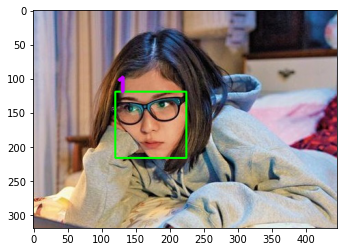

resized image


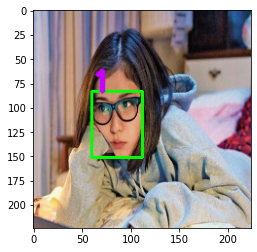

zoom_out image


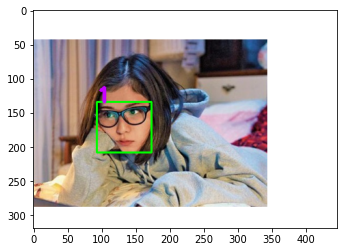

In [9]:
def resizewithbbox(image, bboxes, newsize=[224,224]):
    image = np.array(image)
    h,w,ch = image.shape
    new_w, new_h = newsize[0], newsize[1]
    scale_h, scale_w = new_h/h, new_w/w
    new_image = cv2.resize(image, (new_w, new_h))
    new_image = Image.fromarray(new_image)
    n = len(bboxes)
    new_bboxes = np.array(bboxes)
    if n:
        new_bboxes[:, 0] = new_bboxes[:, 0]*scale_w 
        new_bboxes[:, 1] = new_bboxes[:, 1]*scale_h 
        new_bboxes[:, 2] = new_bboxes[:, 2]*scale_w 
        new_bboxes[:, 3] = new_bboxes[:, 3]*scale_h 
    return new_image, new_bboxes

def zoom_out(image, bboxes):
    image = np.array(image)
    h,w,ch = image.shape
    img_aug = np.ones(image.shape,dtype=np.int8)*255
    
    ratio = np.random.choice([1.05,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9, 2])
    new_w = int(w/ratio)
    new_h = int(h/ratio)
    
    new_img, new_bboxes = resizewithbbox(image, bboxes, [new_w,new_h])
    new_img = np.array(new_img)
    
    remain_w = w - new_w
    remain_h = h - new_h
    if (remain_w>int(w/4))&(remain_h>int(h/4)):
        st_w = np.random.randint(int(w/4), remain_w)
        st_h = np.random.randint(int(h/4), remain_h) 
    else:
        st_w = np.random.randint(0, remain_w)
        st_h = np.random.randint(0, remain_h)
    
    img_aug[st_h:st_h+new_h, st_w:st_w+new_w,:]=new_img
    
    img_aug = Image.fromarray(np.uint8(img_aug))
    
    n = len(new_bboxes)
    new_bboxes = np.array(new_bboxes)
    if n:
        new_bboxes[:, 0] = new_bboxes[:, 0]+st_w  
        new_bboxes[:, 1] = new_bboxes[:, 1]+st_h
        new_bboxes[:, 2] = new_bboxes[:, 2]+st_w  
        new_bboxes[:, 3] = new_bboxes[:, 3]+st_h 
    return img_aug, new_bboxes

for image_id in [10]:    
    image_path = data_train[image_id]
    bboxes = bboxes_train[image_id][1]
    labels = bboxes_train[image_id][0]
    print('original image')
    img = Image.open(image_path, mode='r')
    img = img.convert('RGB')
    imageplot=np.array(img.copy())
    plot_image_withbbox(imageplot, bboxes, labels,flag_bgr=0)

    print('resized image')
    new_img, new_bboxes = resizewithbbox(img, bboxes)
    imageplot=np.array(new_img.copy())
    plot_image_withbbox(imageplot, new_bboxes, labels,flag_bgr=0)
    
    print('zoom_out image')
    new_img, new_bboxes = zoom_out(img, bboxes)
    imageplot=np.array(new_img.copy())
    plot_image_withbbox(imageplot, new_bboxes, labels,flag_bgr=0)

<br>
<font size=3> 
定義Dataloader <br><br>
1. 圖片讀進來後，採用RGB格式<br><br>
2. 圖片和BBOX需要resize到正方形(原因比較好操作後續計算)，此例會將圖片resize到(224x224)<br><br>
3. 如果是training phase則需要做Data Augumentation(我用is_transforms引入)，並且以30%的機率來進行。<br><br>
4. Ground Truth的BBOX座標會被正規化到0~1: <br>所以假設resize後的座標是$(56,112)$，則模型學習的目標會轉換成$(56/224,112/224)=(0.25, 0.5)$ <br><br>
</font>


In [10]:
# image pre-process
process_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ]
)
transforms_dataaug = transforms.ColorJitter(brightness=(0.5, 1.5), 
                                            contrast=(0.5, 1.5), 
                                            saturation=(0.5, 1.5), 
                                            hue=(-18/255, 18/255))

class FaceDataset(Dataset):
    def __init__(self, image_paths, bboxes, newsize=[224,224], is_transforms=False):
        self.is_transforms = is_transforms
        self.image_paths = image_paths
        self.bboxes = bboxes
        self.newsize=newsize
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        path = self.image_paths[idx]
        bboxes = self.bboxes[idx]
        
        # 1.
        img = Image.open(path, mode='r')
        img = img.convert('RGB')
        bboxs = bboxes[1]
        bboxs_class = bboxes[0]
        
        ##### ADD zoom_out
        if self.is_transforms:
            if np.random.random()<0.3:
                img, bboxs = zoom_out(img, bboxs)

        # 2.
        img, bboxs = resizewithbbox(img, bboxs,newsize=self.newsize)
        
        # 3.
        if self.is_transforms:
            if np.random.random()<0.3:
                img = transforms_dataaug(img)
        img = process_transforms(img)
        bboxs_class= torch.tensor(bboxs_class)
        
        # 4.
        bboxs = torch.FloatTensor(bboxs/self.newsize[0])
        return img, bboxs, bboxs_class
    
    def collate_fn(self, batch):
        imgs = list()
        bboxes = list()
        bboxes_class = list()
        for b in batch:
            imgs.append(b[0])
            bboxes.append(b[1])
            bboxes_class.append(b[2])
        imgs=torch.stack(imgs,dim=0)
        return imgs, bboxes, bboxes_class
  

<br>
<font size=3> 
假設圖片為$x$，模型為$f$，偵測目標總共有C類，模型一共預測B個物件框
    
$$
\hat {BBox}_i = f(x), i=1,2,...,B  \\
\hat {BBox}_i = [(\hat x_{min}, \hat y_{min},\hat x_{max}, \hat y_{max}), (p_0, p_1,...,p_C)]
$$
<br>
Ground Truth的BBOX:
$$
BBox_i = [(x_{min}, y_{min},x_{max}, y_{max}), OneHotEncode(C)]
$$

<br>
    
**Loss設計目標:**
    
<br>
1. BBox座標逼近ground truth的座標，我這邊設計用L1 norm:<br>
$$
(\hat x_{min}, \hat y_{min},\hat x_{max}, \hat y_{max}) \to (x_{min}, y_{min},x_{max}, y_{max}) \\
loss(box)=|\hat x_{min} - x_{min}|+|\hat y_{min} - y_{min}|+|\hat x_{max} - x_{max}|+|\hat y_{max} - y_{max}|
$$    
2. BBox分類採Cross Entropy:<br>
$$
loss(CE)=\sum_{i}^{B} CrossEntropy(BBox_i, C)
$$

學習目標:
$$
loss = 2*loss(box) + loss(CE)
$$
    
見 "class LOSS_OD"

</font>


In [11]:
class LOSS_OD(nn.Module):
    def __init__(self, n_bbox, n_class):
        super(LOSS_OD,self).__init__()
        self.n_bbox = n_bbox
        self.n_class = n_class
        self.Softmax= nn.Softmax(dim=2)
    def forward(self,preds_bb, preds_class, bboxs, bboxs_class):
        # preds_bb:  n_batch * (n_bbox*4 =24)
        # preds_class: n_batch * (n_bbox*(n_class+1)= 30)
        # bboxs: batch * n_object * 4
        # bboxs_class: batch * n_object 
        
        n_bbox = self.n_bbox
        n_class = self.n_class
        
        batch_size = preds_bb.size(0)
        
        preds_class = torch.reshape(preds_class,(batch_size, n_bbox, n_class+1)) # (batch, n_bbox, n_class+1)
        preds_class = self.Softmax(preds_class)
        preds_bb = torch.reshape(preds_bb,(batch_size, n_bbox, 4)) # (batch, n_bbox, 4)

        loss_conf,  loss_locs = 0,0
        for b in range(batch_size):
            sub_bboxs = bboxs[b]
            sub_bboxs_class = bboxs_class[b]
            n_object = sub_bboxs.size(0)
            
            if n_object==0:
                continue        
            pred_class=preds_class[b,0:n_object,:] # n_object=1
            pred_bb=preds_bb[b,0:n_object,:]
            
            loss_conf +=  F.cross_entropy(pred_class.view(-1,n_class+1),sub_bboxs_class , reduction="sum")
            loss_locs += F.mse_loss(pred_bb, sub_bboxs, reduction="sum")
        return 2*loss_locs + loss_conf

In [12]:
use_cuda = 1
device = torch.device("cuda:0" if use_cuda else "cpu")
epochs = 50
n_class = 1
n_bbox = 1 # 模型要最多能預測多少物件
lr = 0.001
batch_size = 32

# training -> is_transforms=True
# validation/test -> is_transforms=False
dataset_train = FaceDataset(data_train, bboxes_train, newsize=[224,224], is_transforms=True) 
dataset_val   = FaceDataset(data_val,   bboxes_val,   newsize=[224,224], is_transforms=False) 
train_dl = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=dataset_train.collate_fn )
valid_dl = DataLoader(dataset_val  , batch_size=batch_size, shuffle=True, collate_fn=dataset_val.collate_fn)


checkpoint = torch.load('Model_facedetection_withbackground_augZoomOut.pth')
model = objectdetection_model(n_class=n_class, n_bbox=n_bbox).to(device)
model.load_state_dict(checkpoint['model_dict'])

loss_od = LOSS_OD(n_bbox=n_bbox, n_class=n_class)

# params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    

In [13]:
import time
loss_train_log, loss_val_log=[],[]
loss_all_train_log, loss_all_val_log=[],[]
for e in range(epochs):
    
    # training step
    model.train()
    total, sum_loss = 0, 0
    st=time.time()
    for imgs, bboxs, bboxs_class in train_dl:
        len_batch = imgs.shape[0]
        imgs = imgs.to(device)
        bboxs = [b.to(device) for b in bboxs]
        bboxs_class = [l.to(device) for l in bboxs_class]
        preds_class, preds_bb = model(imgs)
        loss = loss_od(preds_bb, preds_class, bboxs, bboxs_class)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total += len_batch
        sum_loss += loss.item()
        loss_all_train_log.append(loss.item())
    time_train =  time.time()-st
    train_loss = sum_loss / total
    loss_train_log.append(train_loss)
    
    # eval
    model.eval()
    total, sum_loss = 0, 0
    st=time.time()
    for imgs, bboxs, bboxs_class in valid_dl:
        len_batch = imgs.shape[0]
        imgs = imgs.to(device)
        bboxs = [b.to(device) for b in bboxs]
        bboxs_class = [l.to(device) for l in bboxs_class]
        with torch.no_grad():
            preds_class, preds_bb = model(imgs)
            loss = loss_od(preds_bb, preds_class, bboxs, bboxs_class)
            
        total += len_batch
        sum_loss += loss.item()
        loss_all_val_log.append(loss.item())
    time_val =  (time.time()-st) 
    eval_loss = sum_loss / total
    loss_val_log.append(eval_loss)
    if e % 5 == 0:
        print("Epoch[{}/{}], lr={:.6f}, train_loss: {:.4f}, val_loss: {:.4f}, train_time:{:.4f},val_time:{:.4f}".format(e+1,
                                                                                                               epochs,
                                                                                                               scheduler.get_last_lr()[0],
                                                                                                               train_loss, 
                                                                                                               eval_loss,
                                                                                                               time_train,
                                                                                                               time_val))
    scheduler.step()
    

Epoch[1/50], lr=0.001000, train_loss: 1.0654, val_loss: 4.0497, train_time:16.4946,val_time:2.6000
Epoch[6/50], lr=0.001000, train_loss: 0.4971, val_loss: 1.8400, train_time:8.9951,val_time:1.5280
Epoch[11/50], lr=0.000100, train_loss: 0.3631, val_loss: 0.3635, train_time:9.0698,val_time:1.4506
Epoch[16/50], lr=0.000100, train_loss: 0.3470, val_loss: 0.3482, train_time:9.6101,val_time:1.5000
Epoch[21/50], lr=0.000010, train_loss: 0.3468, val_loss: 0.3436, train_time:9.0205,val_time:1.8107
Epoch[26/50], lr=0.000010, train_loss: 0.3412, val_loss: 0.3428, train_time:8.9794,val_time:1.6200
Epoch[31/50], lr=0.000001, train_loss: 0.3392, val_loss: 0.3416, train_time:9.1207,val_time:1.5530
Epoch[36/50], lr=0.000001, train_loss: 0.3382, val_loss: 0.3414, train_time:10.2985,val_time:1.4252
Epoch[41/50], lr=0.000000, train_loss: 0.3457, val_loss: 0.3421, train_time:8.5180,val_time:1.4340
Epoch[46/50], lr=0.000000, train_loss: 0.3371, val_loss: 0.3425, train_time:8.7750,val_time:1.4575


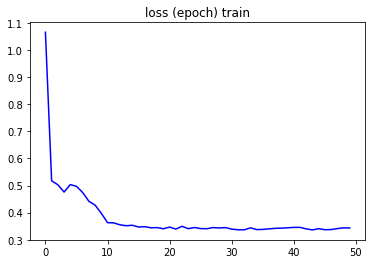

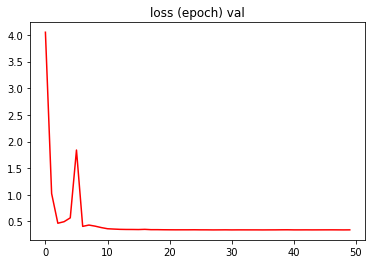

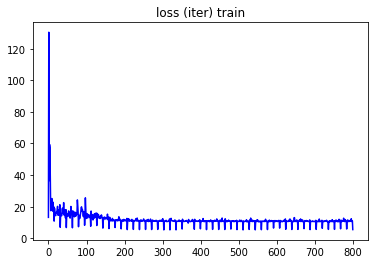

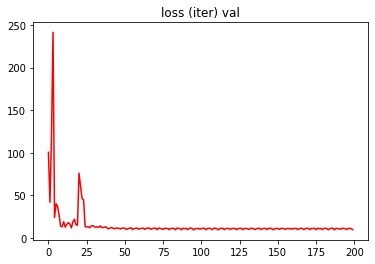

In [14]:
plt.plot(loss_train_log[:],'b')
plt.title('loss (epoch) train')
plt.show()

plt.plot(loss_val_log[:],'r')
plt.title('loss (epoch) val')
plt.show()

plt.plot(loss_all_train_log[:],'b')
plt.title('loss (iter) train')
plt.show()

plt.plot(loss_all_val_log[:],'r')
plt.title('loss (iter) val')
plt.show()


In [15]:
checkpoint={}
checkpoint['loss_train_log']=loss_train_log
checkpoint['loss_val_log']=loss_val_log
checkpoint['loss_all_train_log']=loss_all_train_log
checkpoint['loss_all_val_log']=loss_all_val_log
checkpoint['model_dict'] = model.state_dict()
torch.save(checkpoint, 'Model_facedetection_withbackground_augZoomOut_tommy.pth')
print('Model saved.')

Model saved.


## 4. 模型測試

In [16]:
# load model
use_cuda = 1
n_class = 1
n_bbox = 1
device = torch.device("cuda:0" if use_cuda else "cpu")
checkpoint = torch.load('Model_facedetection_withbackground_augZoomOut_tommy.pth')
model = objectdetection_model(n_class=n_class, n_bbox=n_bbox).to(device)
model.load_state_dict(checkpoint['model_dict'])

<All keys matched successfully>

Inference Image:datasets\FaceDetection\images\phpH7gsJi.jpg
original image


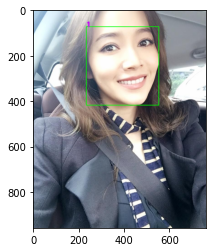

Detection image


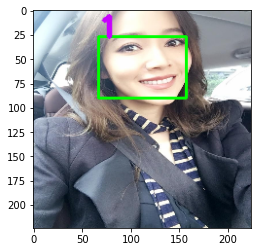

Inference Image:datasets\FaceDetection\images\20180601165834-83b8629332ca6ba5696a2e76c17b3e2d-mobile.jpg
original image


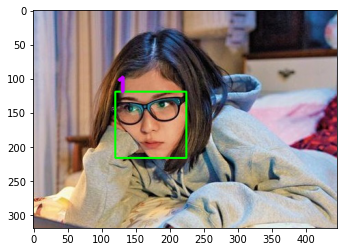

Detection image


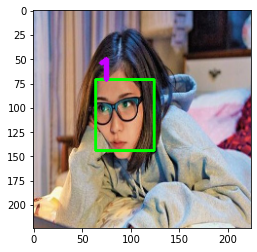

Inference Image:datasets\FaceDetection\images\30-309234_facetite-model-female-side-face-png.jpg
original image


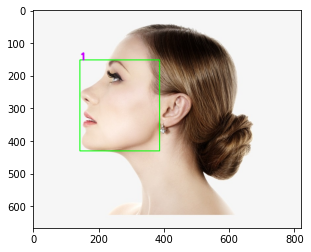

Detection image


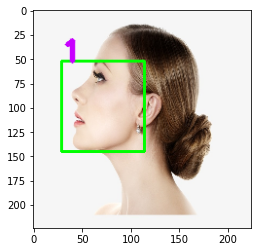

Inference Image:datasets\FaceDetection\images\20200730005302.jpg
original image


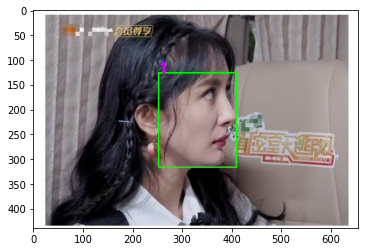

Detection image


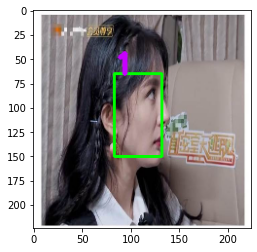

Inference Image:datasets\FaceDetection\images\66609956_485135035647665_9174969680059685218_n.jpg
original image


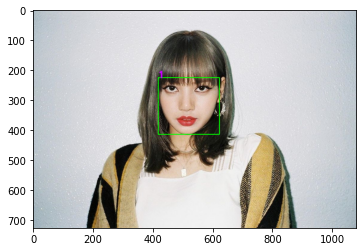

Detection image


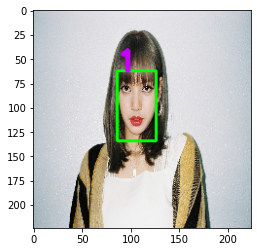

Inference Image:datasets\FaceDetection\images\03sideface55.jpg
original image


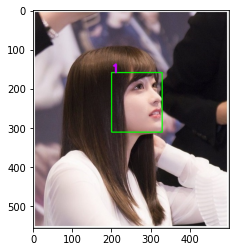

Detection image


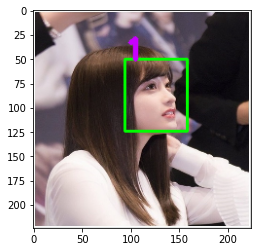

In [17]:
for image_id in [1,10,20,30,40,50]:
    image_path = data_train[image_id]
    bboxs = bboxes_train[image_id][1]
    bboxs_class = bboxes_train[image_id][0]
    # image_path = data_val[image_id]
    # bboxs = bboxes_val[image_id][1]
    # bboxs_class = bboxes_val[image_id][0]
    print('Inference Image:{}'.format(image_path))
    print('original image')
    img = Image.open(image_path, mode='r')
    img = img.convert('RGB')
    imageplot=np.array(img.copy())
    plot_image_withbbox(imageplot, bboxs, bboxs_class, flag_bgr=0)


    print('Detection image')
    img, bboxs = resizewithbbox(img, bboxs,newsize=[224,224])
    resize_img=np.array(img.copy())
    img = process_transforms(img) # 3*224*224
    img = img.unsqueeze(dim=0)#  1 * 3*224*224

    model.eval()
    with torch.no_grad():
        preds_class, preds_bb = model(img.to(device)) # batch*3*224*224


    preds_bb = preds_bb[0]
    preds_bb = torch.reshape(preds_bb,(n_bbox, 4)) # (batch, n_bbox, 4)
    preds_bb = preds_bb.detach().cpu().numpy()
    preds_bb = preds_bb*224



    preds_class = preds_class[0]
    preds_class = torch.reshape(preds_class,(n_bbox, n_class+1)) # ( n_bbox, n_class+1)
    preds_class = nn.Softmax(dim=1)(preds_class)
    v, ind = torch.max(preds_class,dim=1)
    v = v.detach().cpu().numpy()
    ind = ind.detach().cpu().numpy()
    p_bbox, final_bbox=[],[]
    final_label=[]
    for i,tmp_ind in enumerate(ind):
        if tmp_ind > 0:
            p_bbox.append(preds_class[i,tmp_ind])
            final_bbox.append(preds_bb[i,:])
            final_label.append(tmp_ind)
    plot_image_withbbox(resize_img, final_bbox,final_label, flag_bgr=0)


# Note: 物件對應表在前面定義在 labelmap = {'background':0, 'trafficlight': 1, 'speedlimit': 2, 'crosswalk': 3, 'stop': 3}

 

In [18]:
use_cuda = 1
n_class = 1
n_bbox = 1
device = torch.device("cpu")
checkpoint = torch.load('Model_OD_facedetection_withbackground.pth')
model = objectdetection_model(n_class=n_class, n_bbox=n_bbox).to(device)
model.load_state_dict(checkpoint['model_dict'])
model.eval()
dummpy_input = torch.randn(1, 3, 224, 224)
torch.onnx.export(model, 
                  dummpy_input, 
                  'Model_facedetection_withbackground_augZoomOut_tommy.onnx', 
                  opset_version=11)